Modify inspect_spectra for alt binning (subject pairwise)

In [2]:
import sys
from pathlib import Path
notebook_dir = Path('/home/chan21/indiv_dim/notebooks')
#notebook_dir = Path().absolute()
while not (notebook_dir / 'src').exists():
    notebook_dir = notebook_dir.parent
    
if str(notebook_dir) not in sys.path:
    sys.path.append(str(notebook_dir))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pathlib import Path
from src.utils._config import *
from src.utils._io import *
from src.utils._paths import *
from src.spectra._definition import *
from src.utils.plot import *
import argparse
from tqdm import tqdm
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

HOME_DIR = Path("/data/chan21/idim-debug-spectra")
mpl.rcParams.update(DEFAULT_MATPLOTLIBRC)
sns.set_theme(style="ticks", rc=DEFAULT_MATPLOTLIBRC, context="poster")


Configure spectra

In [20]:
movies = ['iteration', 'defeat', 'growth', 'lemonade']
rois = ['occipital', 'ventral', 'temporal', 'semantic', 'pmc']
rois_names = {'occipitotemporal': 'OccTC',
                'occipital': 'early',
              'ventral': 'ventral',
              'temporal': 'lateral',
              'semantic': 'temporoparietal',
              'pmc': 'posteromedial',}
metric = 'cov'
color="magma"
roi_colors = sns.color_palette(color, 5)

# min_length = 1430
# slope = -1.6 if metric == 'cov' else -0.4
# indices = np.arange(1, min_length + 1)
# bin_assignments = [assign_data_to_geometrically_spaced_bins(
#     index + 1,
#     density=3,
#     start=1,
#     stop=10_000) for index in indices]
# unique_bins = np.unique(bin_assignments)

Load spectra

In [4]:
# Observed spectra
roi_spectra = {
    roi: {} for roi in rois
}
for i, roi in enumerate(rois):
    if roi == 'pmc':
        eigenspectra_path = Path("/home/chan21/indiv_dim/results/") / f"{metric}_{roi}_functional" / "eigenspectra.h5" #HOME_DIR / "results" / f"{metric}_{roi}_functional" / "eigenspectra.h5"
    else:
        eigenspectra_path = Path("/data/chan21/idim-debug-spectra/results/") / f"{metric}_{roi}_functional_perm" / "eigenspectra.h5" #HOME_DIR / "results" / f"{metric}_{roi}_functional" / "eigenspectra.h5"
    with h5py.File(eigenspectra_path, 'r') as f:
        h5 = f['data']
        for key in h5.keys():
            roi_spectra[roi][key] = h5[key]['observed'][:]

min_length = min(spectrum.shape[0] for spectrum in roi_spectra[rois[0]].values())
indices=np.arange(1, min_length) # Start from 1 to avoid binning the first and second ranks
bin_assignments = [assign_data_to_geometrically_spaced_bins(
    index + 1,
    density=3,
    start=1,
    stop=10_000) for index in indices]
unique_bins = np.unique(bin_assignments)

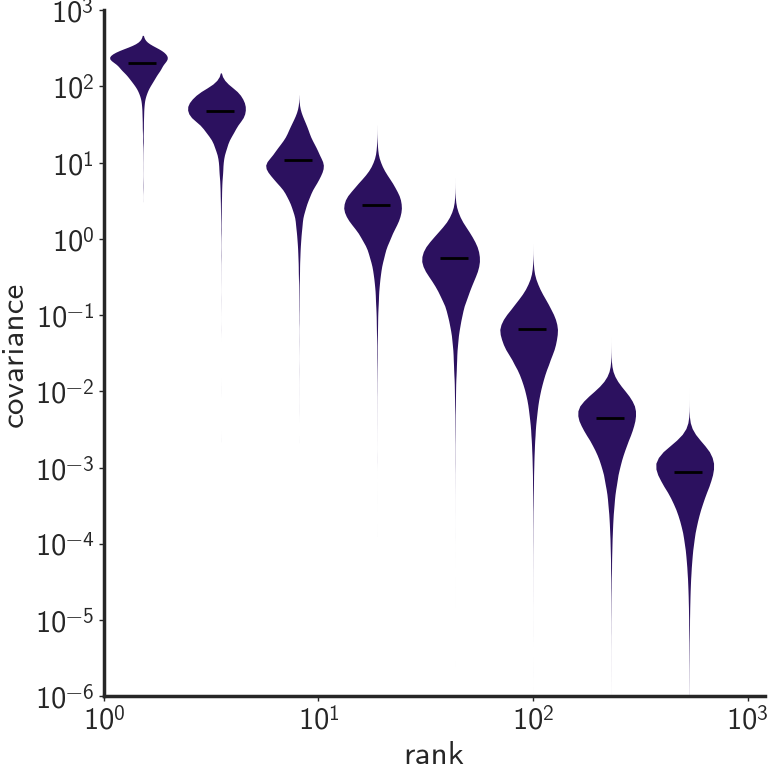

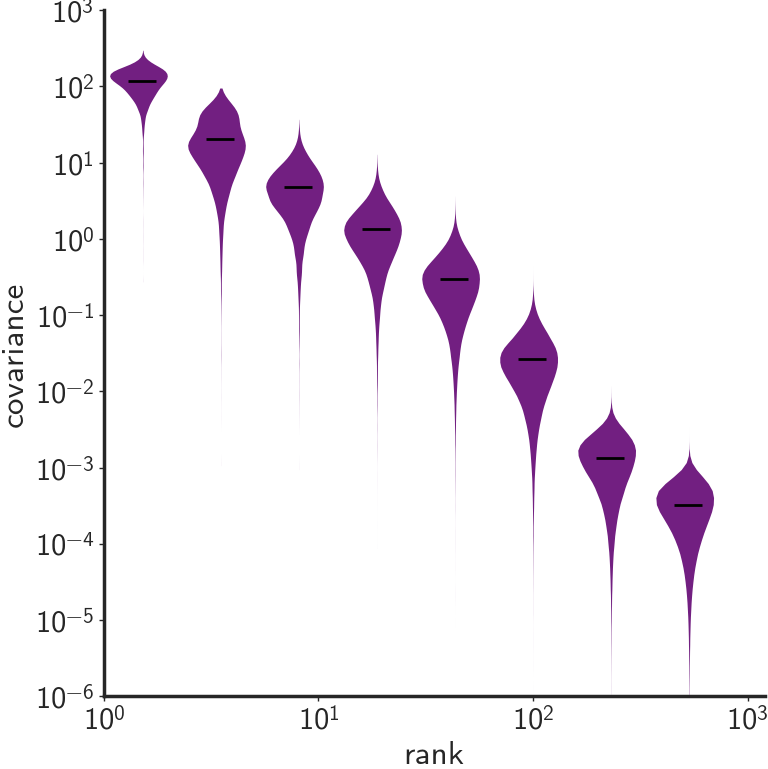

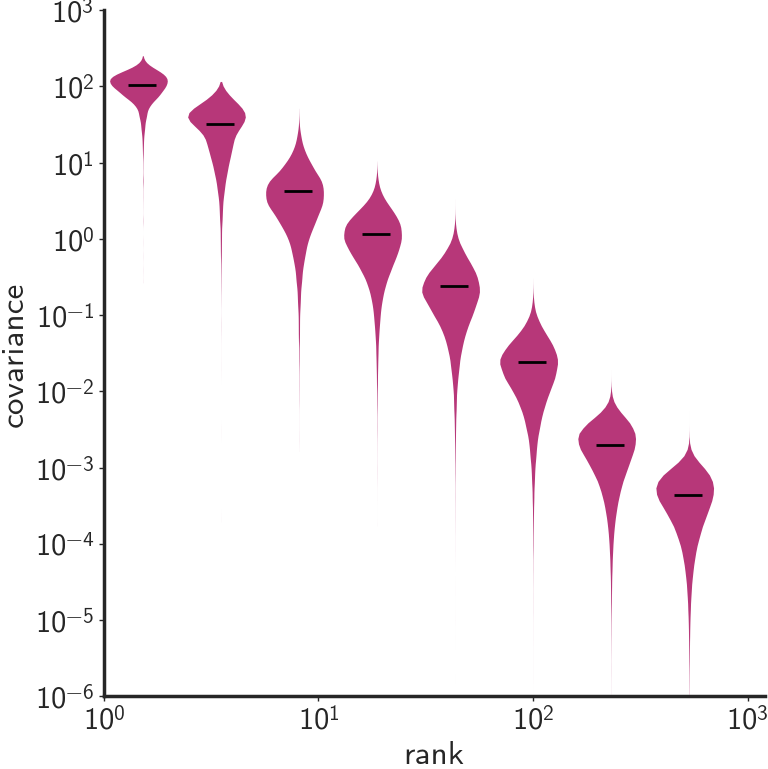

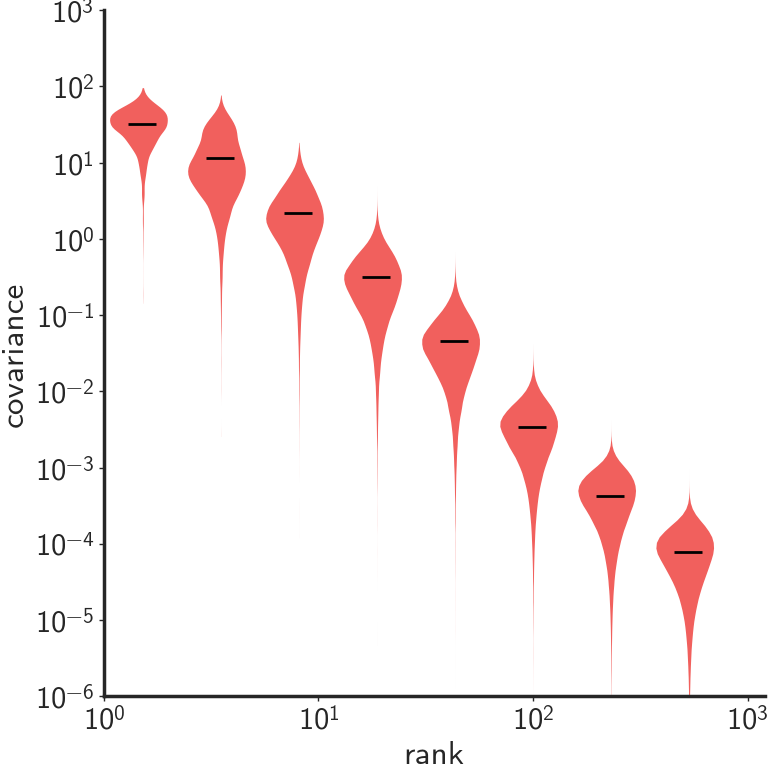

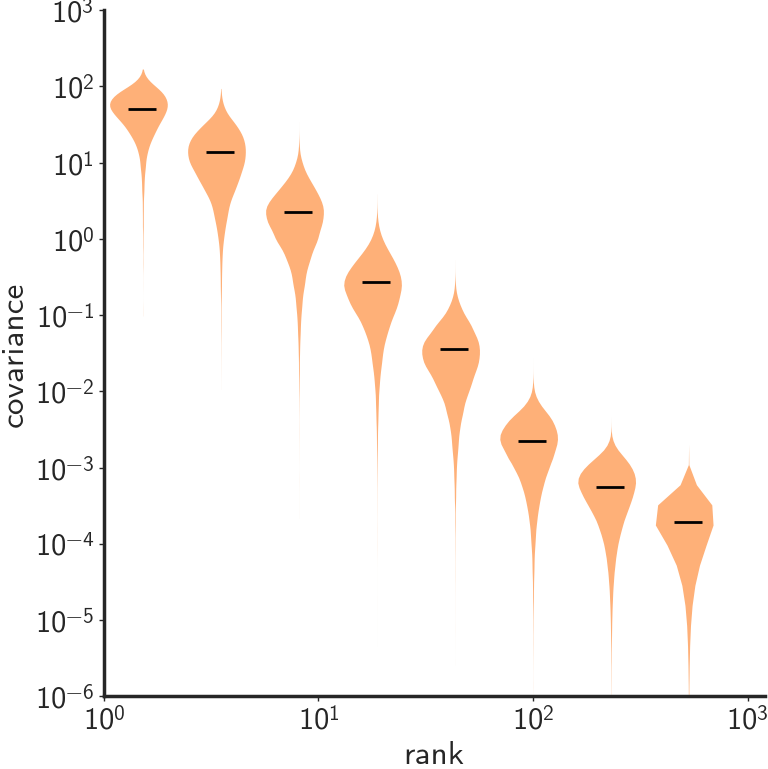

In [ ]:
import json

for roi in rois:
    # with open(f"/home/chan21/indiv_dim/results/nvoxels_{roi}_functional_voxel_counts.json", 'r') as f:
    #     voxel_dict = json.load(f)

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # Collect data
    all_binned_spectrum = {bin: [] for bin in unique_bins}
    for key in roi_spectra[roi].keys():
        spectrum = roi_spectra[roi][key]
        subject_pair = key.split('_')[0] + '_' + key.split('_')[1]
        #spectrum = spectrum / voxel_dict[subject_pair] # normalize by number of voxels
        for bin, value in zip(bin_assignments, spectrum):
            all_binned_spectrum[bin].append(value)

    all_binned_values = [np.array(all_binned_spectrum[bin]) for bin in unique_bins]


    # Plot violins
    for idx, (pos, data) in enumerate(zip(unique_bins[:-1], all_binned_values[:-1])):
        original_data = data.copy()  # Keep original data including negatives
        data_positive = data[data > 0]  # Remove zeros or negative values for violin plot
        
        if len(data_positive) > 0:
            # Calculate the true mean from all data (including negatives)
            true_mean = np.mean(original_data)
            positive_mean = np.mean(data_positive)
            
            # Calculate shift needed to align with true mean
            shift = np.log10(true_mean) - np.log10(positive_mean) if positive_mean > 0 else 0
            
            # Calculate KDE in log space
            log_data = np.log10(data_positive)
            kernel = stats.gaussian_kde(log_data)
            
            # Use exact data range
            log_min, log_max = log_data.min(), log_data.max()
            log_space = np.linspace(log_min, log_max, 100)
            density = kernel(log_space)
            
            # Apply shift and convert back to linear space
            log_space = log_space + shift
            x = np.power(10, log_space)
            
            # Plot violin
            width = 0.3 * pos
            scaled_density = density / density.max() * width

            ax.fill_betweenx(x, pos - scaled_density, pos + scaled_density, 
                            alpha=1, color=roi_colors[rois.index(roi)])
            # Add mean line using true mean
            ax.hlines(true_mean, pos - width/2, pos + width/2, color='black', linewidth=2)
        

    # Set scales and limits
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1, 1700)
    #ax.set_ylim(1e-10, 1e-1) if metric == 'cov' else ax.set_xlim(1e-3, 1e0)
    ax.set_ylim(1e-6, 1e3) if metric == 'cov' else ax.set_ylim(1e-3, 1e0)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('rank')
    ax.set_ylabel('covariance' if metric == 'cov' else 'correlation')
    # ax.set_yticklabels([])
    # ax.set_yticks([10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3])


    #plt.show()
    # save as svg
    plt.savefig(f'figure1_{roi}.svg', dpi=300, bbox_inches='tight')

Slope for occipital using first 5 bins: -1.7425064262422916
Slope for occipital using first 6 bins: -1.87199714690489
Slope for occipital using first 7 bins: -2.0626042525527515
Slope for occipital using first 8 bins: -2.12963989199912


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


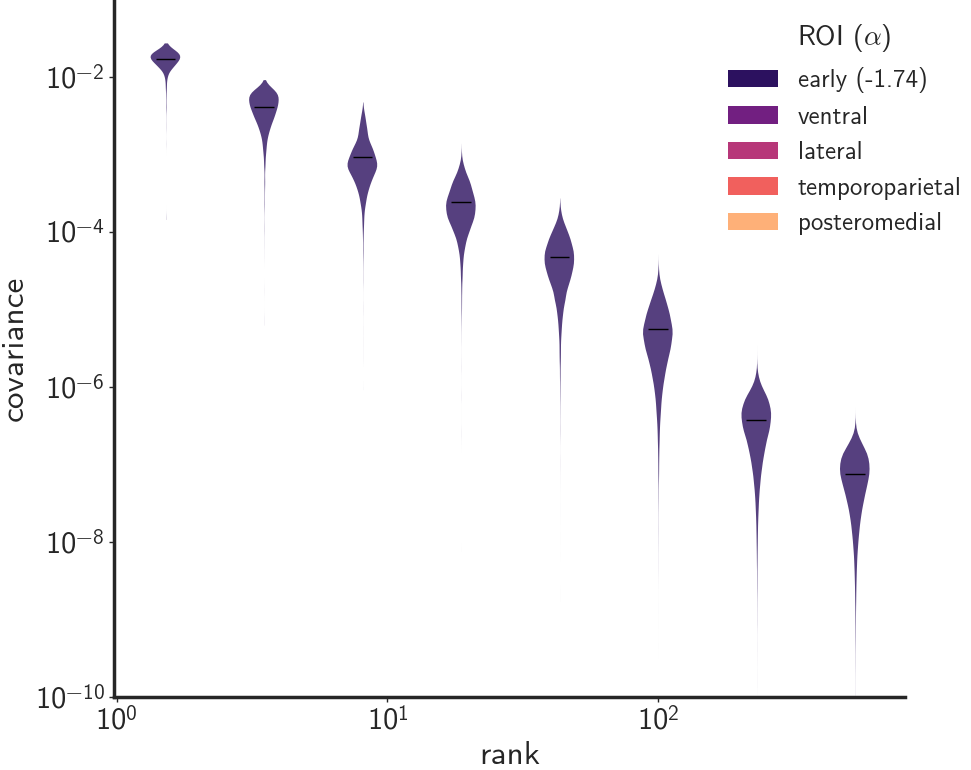

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import stats
from scipy.optimize import curve_fit

# Create a single figure for all ROIs
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Define offset values for each ROI - using 0.2 as requested
roi_offsets = {roi: i * 0.2 for i, roi in enumerate(rois)}

# Calculate power law slopes
def fit_power_law(x_data, y_data):
    # Convert to log space for better fitting
    log_x = np.log10(x_data)
    log_y = np.log10(y_data)
    
    # Remove any inf or nan values
    valid_indices = np.isfinite(log_x) & np.isfinite(log_y)
    log_x = log_x[valid_indices]
    log_y = log_y[valid_indices]
    
    # Simple linear fit in log space
    if len(log_x) > 1:
        coeffs = np.polyfit(log_x, log_y, 1)
        return coeffs[0]  # Slope in log-log space = power law exponent
    else:
        return np.nan

# Dictionary to store slopes for each ROI
slopes = {}

draw_idx = 1
# Process each ROI
for roi_idx, roi in enumerate(rois[:draw_idx]):
    #Read voxel counts
    with open(f"/home/chan21/indiv_dim/results/nvoxels_{roi}_functional_voxel_counts.json", 'r') as f:
        voxel_dict = json.load(f)
    
    # Average spectra across movies for each subject pair
    averaged_spectra = {}
    spectra_counts = {}
    
    # Group and sum spectra by subject pair
    for key in roi_spectra[roi].keys():
        parts = key.split('_')
        subject_pair = f"{parts[0]}_{parts[1]}"  # Extract 'sub-id1_sub-id2'
        
        spectrum = roi_spectra[roi][key]
        if subject_pair not in averaged_spectra:
            
            averaged_spectra[subject_pair] = np.zeros(min_length)
            spectra_counts[subject_pair] = 0
        try:
            averaged_spectra[subject_pair] += spectrum[:min_length]  # Ensure same length
            spectra_counts[subject_pair] += 1
        except:
            continue

    # Calculate averages
    for subject_pair in averaged_spectra:
        averaged_spectra[subject_pair] /= spectra_counts[subject_pair]
    
    # Collect data for this ROI using averaged spectra
    all_binned_spectrum = {bin: [] for bin in unique_bins}
    for subject_pair, spectrum in averaged_spectra.items():
        normalized_spectrum = spectrum / voxel_dict[subject_pair]  # normalize by number of voxels
        for bin, value in zip(bin_assignments, normalized_spectrum):
            all_binned_spectrum[bin].append(value)
    
    # Calculate slope for this ROI
    ranks = []
    means = []
    for bin_val in unique_bins[:8]:  # Only use first 8 bins for slope calculation
        if len(all_binned_spectrum[bin_val]) > 0:
            ranks.append(bin_val)
            means.append(np.nanmean(all_binned_spectrum[bin_val]))
    
    if len(ranks) > 2:
        for i in range(5, 9):
            slope = fit_power_law(np.array(ranks[:i]), np.array(means[:i]))
            print(f"Slope for {roi} using first {i} bins: {slope}")
        slope = fit_power_law(np.array(ranks[:5]), np.array(means[:5])) # Use only first 5 bins for slope
        slopes[roi] = slope
    
    # Get data for violin plots - only use first 8 bins
    display_bins = unique_bins[:8]  # Only use first 8 bins for display
    all_binned_values = [np.array(all_binned_spectrum[bin]) for bin in display_bins]
    offset = roi_offsets[roi]
    
    # Plot violins with offset
    for idx, (pos, data) in enumerate(zip(display_bins, all_binned_values)):
        original_data = data.copy()
        data_positive = data[data > 0]  # Remove zeros or negative values
        
        if len(data_positive) > 0:
            # Calculate the true mean
            true_mean = np.nanmean(original_data)
            positive_mean = np.nanmean(data_positive)
            
            # Calculate shift needed
            shift = np.log10(true_mean) - np.log10(positive_mean) if positive_mean > 0 else 0
            
            # Calculate KDE in log space
            log_data = np.log10(data_positive)
            kernel = stats.gaussian_kde(log_data)
            
            log_min, log_max = log_data.min(), log_data.max()
            log_space = np.linspace(log_min, log_max, 100)
            density = kernel(log_space)
            
            # Apply shift and convert back to linear space
            log_space = log_space + shift
            x = np.power(10, log_space)
            
            # Plot violin with position offset
            width = 0.25 * pos
            scaled_density = density / density.max() * width / 2  # Reduce width
            
            # Apply offset to position
            adjusted_pos = pos * (1 + offset)
            
            ax.fill_betweenx(x, adjusted_pos - scaled_density, adjusted_pos + scaled_density,
                            alpha=0.8, color=roi_colors[roi_idx])
            
            # Add mean line - simplified, thinner
            ax.hlines(true_mean, adjusted_pos - width/3, adjusted_pos + width/3, 
                     color='black', linewidth=1.0)

# Create custom legend with patches
handles = []
labels = []
for roi_idx, roi in enumerate(rois):
    roi_name = rois_names[roi]
    patch = plt.Rectangle((0, 0), 1, 1, color=roi_colors[roi_idx])
    handles.append(patch)
    if roi in slopes:
        labels.append(f"{roi_name} ({slopes[roi]:.2f})")
    else:
        labels.append(roi_name)

# Add legend
ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18, title=r"ROI ($\alpha$)", title_fontsize=20)
# Set scales and limits
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(1, 1070)  # Adjusted to only show up to the 8th bin range
ax.set_ylim(1e-10, 1e-1)  # Adjust as needed for the metric
#ax.set_ylim(1e-6, 1e3) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('rank')
ax.set_ylabel('covariance')  # Adjust based on your metric
plt.tight_layout()

# Update filename to indicate movie averaging
plt.savefig(f'/home/chan21/indiv_dim/notebooks/figures/figure1_combined_roi_norm_{draw_idx}_movie_averaged.svg', dpi=300, bbox_inches='tight')
plt.savefig(f'/home/chan21/indiv_dim/notebooks/figures/figure1_combined_roi_norm_{draw_idx}_movie_averaged.pdf', dpi=300, bbox_inches='tight')
plt.show()

Slope for occipital using first 5 bins: -1.7425064262422916
Slope for occipital using first 6 bins: -1.87199714690489
Slope for occipital using first 7 bins: -2.0626042525527515
Slope for occipital using first 8 bins: -2.129639891999121


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


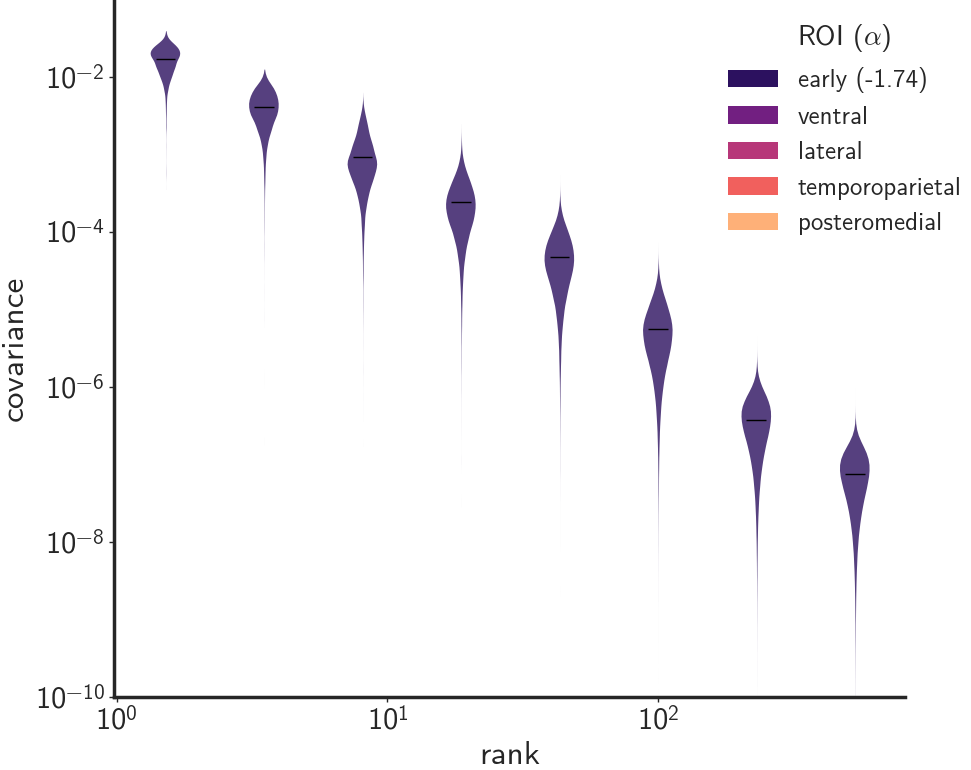

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import stats
from scipy.optimize import curve_fit

# Create a single figure for all ROIs
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Define offset values for each ROI - using 0.2 as requested
roi_offsets = {roi: i * 0.2 for i, roi in enumerate(rois)}

# Calculate power law slopes
def fit_power_law(x_data, y_data):
    # Convert to log space for better fitting
    log_x = np.log10(x_data)
    log_y = np.log10(y_data)
    
    # Remove any inf or nan values
    valid_indices = np.isfinite(log_x) & np.isfinite(log_y)
    log_x = log_x[valid_indices]
    log_y = log_y[valid_indices]
    
    # Simple linear fit in log space
    if len(log_x) > 1:
        coeffs = np.polyfit(log_x, log_y, 1)
        return coeffs[0]  # Slope in log-log space = power law exponent
    else:
        return np.nan

# Dictionary to store slopes for each ROI
slopes = {}

draw_idx = 1
# Process each ROI
for roi_idx, roi in enumerate(rois[:draw_idx]):
    #Read voxel counts
    with open(f"/home/chan21/indiv_dim/results/nvoxels_{roi}_functional_voxel_counts.json", 'r') as f:
        voxel_dict = json.load(f)
    
    # Collect data for this ROI
    all_binned_spectrum = {bin: [] for bin in unique_bins}
    for key in roi_spectra[roi].keys():
        spectrum = roi_spectra[roi][key]
        subject_pair = key.split('_')[0] + '_' + key.split('_')[1]
        spectrum = spectrum / voxel_dict[subject_pair]  # normalize by number of voxels
        for bin, value in zip(bin_assignments, spectrum):
            all_binned_spectrum[bin].append(value)
    
    # Calculate slope for this ROI
    ranks = []
    means = []
    for bin_val in unique_bins[:8]:  # Only use first 8 bins for slope calculation
        if len(all_binned_spectrum[bin_val]) > 0:
            ranks.append(bin_val)
            means.append(np.mean(all_binned_spectrum[bin_val]))
    
    if len(ranks) > 2:
        for i in range(5, 9):
            slope = fit_power_law(np.array(ranks[:i]), np.array(means[:i]))
            print(f"Slope for {roi} using first {i} bins: {slope}")
        slope = fit_power_law(np.array(ranks[:5]), np.array(means[:5])) # Use only first 5 bins for slope
        slopes[roi] = slope
    
    # Get data for violin plots - only use first 8 bins
    display_bins = unique_bins[:8]  # Only use first 8 bins for display
    all_binned_values = [np.array(all_binned_spectrum[bin]) for bin in display_bins]
    offset = roi_offsets[roi]
    
    # Plot violins with offset
    for idx, (pos, data) in enumerate(zip(display_bins, all_binned_values)):
        original_data = data.copy()
        data_positive = data[data > 0]  # Remove zeros or negative values
        
        if len(data_positive) > 0:
            # Calculate the true mean
            true_mean = np.mean(original_data)
            positive_mean = np.mean(data_positive)
            
            # Calculate shift needed
            shift = np.log10(true_mean) - np.log10(positive_mean) if positive_mean > 0 else 0
            
            # Calculate KDE in log space
            log_data = np.log10(data_positive)
            kernel = stats.gaussian_kde(log_data)
            
            log_min, log_max = log_data.min(), log_data.max()
            log_space = np.linspace(log_min, log_max, 100)
            density = kernel(log_space)
            
            # Apply shift and convert back to linear space
            log_space = log_space + shift
            x = np.power(10, log_space)
            
            # Plot violin with position offset
            width = 0.25 * pos
            scaled_density = density / density.max() * width / 2  # Reduce width
            
            # Apply offset to position
            adjusted_pos = pos * (1 + offset)
            
            ax.fill_betweenx(x, adjusted_pos - scaled_density, adjusted_pos + scaled_density,
                            alpha=0.8, color=roi_colors[roi_idx])
            
            # Add mean line - simplified, thinner
            ax.hlines(true_mean, adjusted_pos - width/3, adjusted_pos + width/3, 
                     color='black', linewidth=1.0)

# Create custom legend with patches
handles = []
labels = []
for roi_idx, roi in enumerate(rois):
    roi_name = rois_names[roi]
    patch = plt.Rectangle((0, 0), 1, 1, color=roi_colors[roi_idx])
    handles.append(patch)
    if roi in slopes:
        labels.append(f"{roi_name} ({slopes[roi]:.2f})")
    else:
        labels.append(roi_name)

# Add legend
ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18, title=r"ROI ($\alpha$)", title_fontsize=20)
# Set scales and limits
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(1, 1070)  # Adjusted to only show up to the 8th bin range
ax.set_ylim(1e-10, 1e-1)  # Adjust as needed for the metric
#ax.set_ylim(1e-6, 1e3) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('rank')
ax.set_ylabel('covariance')  # Adjust based on your metric
plt.tight_layout()
plt.savefig(f'/home/chan21/indiv_dim/notebooks/figures/figure1_combined_roi_norm_{draw_idx}.svg', dpi=300, bbox_inches='tight')
plt.savefig(f'/home/chan21/indiv_dim/notebooks/figures/figure1_combined_roi_norm_{draw_idx}.pdf', dpi=300, bbox_inches='tight')
#plt.show()

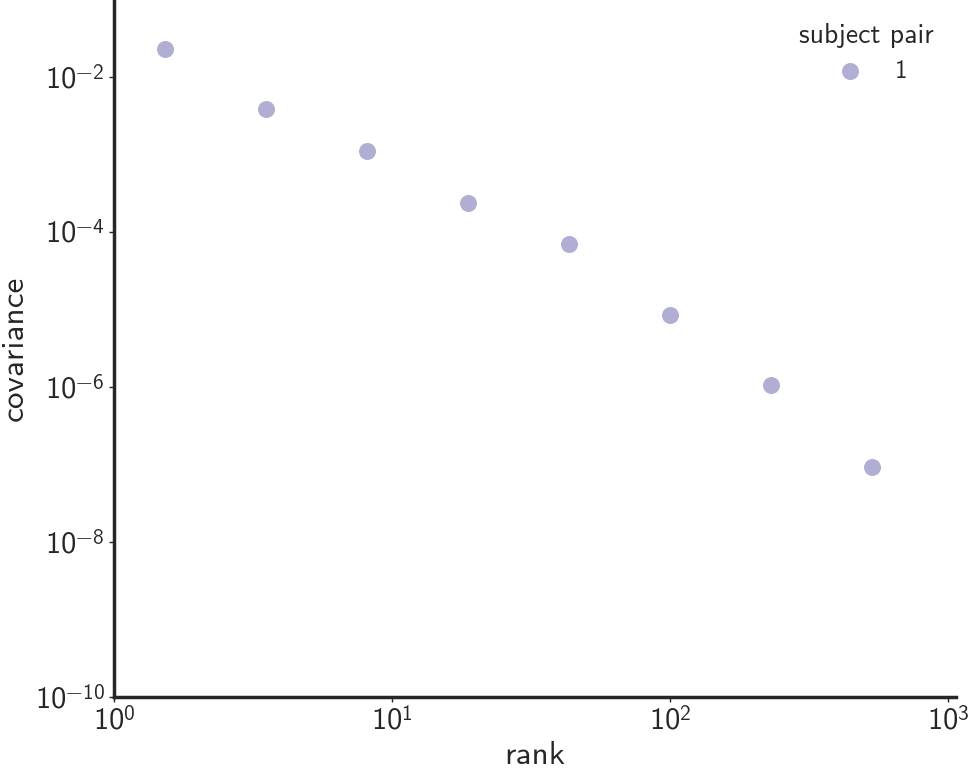

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import stats

def plot_sample_spectra(rois, roi_spectra, average=True, num_pairs=1, roi_idx=0):
    """
    Plot rank-binned movie-averaged spectrum for sample subject pairs.
    
    Parameters:
    -----------
    rois : list
        List of ROI names
    roi_spectra : dict
        Dictionary containing spectra for each ROI
    average : bool
        Whether to average the spectra across movies (default: True)
    num_pairs : int
        Number of subject pairs to display (default: 1)
    roi_idx : int
        Index of the ROI to use (default: 0)
    """
    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Select the ROI
    roi = rois[roi_idx]
    
    # Load voxel counts for normalization
    with open(f"/home/chan21/indiv_dim/results/nvoxels_{roi}_functional_voxel_counts.json", 'r') as f:
        voxel_dict = json.load(f)
    
    # Average spectra across movies for each subject pair
    averaged_spectra = {}
    spectra_counts = {}
    
    if average:
        # Group and sum spectra by subject pair
        for key in roi_spectra[roi].keys():
            parts = key.split('_')
            subject_pair = f"{parts[0]}_{parts[1]}"  # Extract 'sub-id1_sub-id2'
            
            spectrum = roi_spectra[roi][key]
            if subject_pair not in averaged_spectra:
                averaged_spectra[subject_pair] = np.zeros((min_length))
                spectra_counts[subject_pair] = 0
            averaged_spectra[subject_pair] += spectrum[:min_length]  # Ensure same length
            spectra_counts[subject_pair] += 1
        
        # Calculate averages
        for subject_pair in averaged_spectra:
            averaged_spectra[subject_pair] /= spectra_counts[subject_pair]
    else:
        # If not averaging, just use the spectra directly
        for key in roi_spectra[roi].keys():
            parts = key.split('_')
            subject_pair = f"{parts[0]}_{parts[1]}"
            spectrum = roi_spectra[roi][key]
            averaged_spectra[subject_pair] = spectrum[:min_length]  # Ensure same length
            spectra_counts[subject_pair] = 1
            # Calculate averages
            averaged_spectra[subject_pair] /= spectra_counts[subject_pair]
    
    
    # Get a list of all available subject pairs
    all_pairs = list(averaged_spectra.keys())
    
    # Select sample pairs (either specific ones or random if not found)
    sample_pairs = []
    
    # Try to find the specific pair mentioned in the example
    example_pair = 'sub-NSD103_sub-NSD104'
    if example_pair in all_pairs:
        sample_pairs.append(example_pair)
    
    # If we need more pairs or didn't find the example pair,
    # select random pairs from the available ones
    pool = [pair for pair in all_pairs if pair not in sample_pairs]
    for pair in pool:
        if pair not in sample_pairs and len(sample_pairs) < num_pairs:
            sample_pairs.append(pair)
    
    # Plot data for each sample pair
    colors = sns.color_palette("Purples", num_pairs)
    
    for i, pair in enumerate(sample_pairs[:num_pairs]):
        # Get the spectrum and normalize by voxel count
        spectrum = averaged_spectra[pair] / voxel_dict[pair]
        
        # Bin the data
        binned_data = {}
        for bin_val, value in zip(bin_assignments, spectrum):
            if bin_val not in binned_data:
                binned_data[bin_val] = []
            binned_data[bin_val].append(value)
        
        # Calculate mean for each bin
        x_values = []
        y_values = []
        for bin_val in sorted(binned_data.keys()):
            x_values.append(bin_val)
            y_values.append(np.mean(binned_data[bin_val]))
        
        # Plot the data
        ax.scatter(x_values, y_values, color=colors[i % len(colors)], s=150, alpha=0.8,
                  label=f"{i+1}")
    
    # Set scales and limits similar to the example
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1, 1070)  # Adjusted to only show up to the 8th bin range
    ax.set_ylim(1e-10, 1e-1)
    
    # Clean up the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlabel('rank')
    ax.set_ylabel('covariance')
    
    # Add legend only if showing multiple pairs
    ax.legend(loc='upper right', frameon=False, title="subject pair", fontsize=18, title_fontsize=20, ncol=2)
    
    plt.tight_layout()
    
    # Save the figure
    #plt.savefig(f'/home/chan21/indiv_dim/notebooks/figures/sample_pair_spectrum_{num_pairs}_pairs.svg', 
    #           dpi=300, bbox_inches='tight')
    #plt.savefig(f'/home/chan21/indiv_dim/notebooks/figures/sample_pair_spectrum_{num_pairs}_pairs.pdf', 
     #          dpi=300, bbox_inches='tight')
    
    # Uncomment to display the plot
    plt.show()
    
    plt.close()

# Example usage:
plot_sample_spectra(rois, roi_spectra, average=False, num_pairs=1)
#plot_sample_spectra(rois, roi_spectra, num_pairs=2)

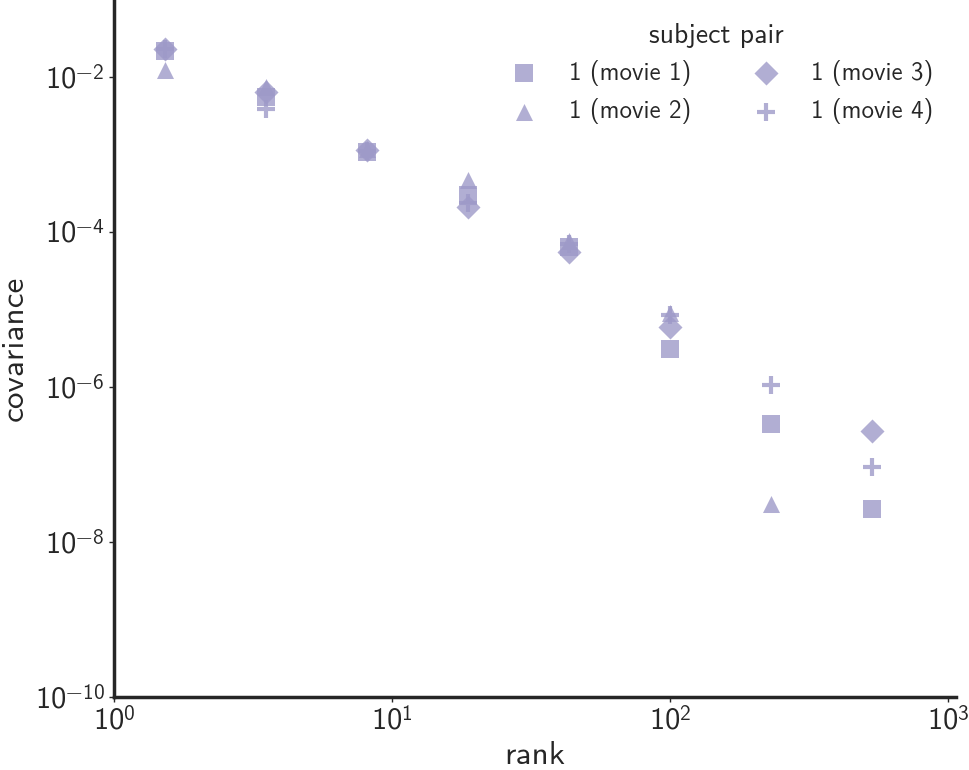

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import stats
import seaborn as sns

def plot_sample_spectra(rois, roi_spectra, average=True, movies=None, num_pairs=1, roi_idx=0):
    """
    Plot rank-binned spectrum for sample subject pairs.
    
    Parameters:
    -----------
    rois : list
        List of ROI names
    roi_spectra : dict
        Dictionary containing spectra for each ROI
    average : bool
        Whether to average the spectra across movies (default: True)
    movies : list or None
        List of movie indices to include (e.g., [0], [1, 3], [0,1,2,3])
        Only used when average=False
    num_pairs : int
        Number of subject pairs to display (default: 1)
    roi_idx : int
        Index of the ROI to use (default: 0)
    """
    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Select the ROI
    roi = rois[roi_idx]
    
    # Load voxel counts for normalization
    with open(f"/home/chan21/indiv_dim/results/nvoxels_{roi}_functional_voxel_counts.json", 'r') as f:
        voxel_dict = json.load(f)
    
    # Find minimum length of all spectra to ensure consistent sizes
    min_length = float('inf')
    for key in roi_spectra[roi].keys():
        min_length = min(min_length, len(roi_spectra[roi][key]))
    
    # Process spectra - either average across movies or select specific movies
    if average:
        # Group and sum spectra by subject pair as before
        averaged_spectra = {}
        spectra_counts = {}
        
        for key in roi_spectra[roi].keys():
            parts = key.split('_')
            subject_pair = f"{parts[0]}_{parts[1]}"  # Extract 'sub-id1_sub-id2'
            
            spectrum = roi_spectra[roi][key]
            if subject_pair not in averaged_spectra:
                averaged_spectra[subject_pair] = np.zeros(min_length)
                spectra_counts[subject_pair] = 0
            
            averaged_spectra[subject_pair] += spectrum[:min_length]
            spectra_counts[subject_pair] += 1
        
        # Calculate averages
        for subject_pair in averaged_spectra:
            averaged_spectra[subject_pair] /= spectra_counts[subject_pair]
        
        # We'll use this dictionary for plotting
        plot_data = averaged_spectra
        
    else:
        # If not averaging, select specific movies for each pair
        if movies is None:
            # Default to all movies if not specified
            movies = [0, 1, 2, 3]
        
        markers = ['s', '^', 'D', '+']  # Different markers for different movies
        # Organize spectra by subject pair and movie index
        movie_specific_spectra = {}
        
        # Get all unique movie names
        all_movies = []
        movie_to_idx = {}
        
        for key in roi_spectra[roi].keys():
            parts = key.split('_')
            movie_name = '_'.join(parts[2:])  # Extract movie name
            if movie_name not in all_movies:
                movie_to_idx[movie_name] = len(all_movies)
                all_movies.append(movie_name)
        
        # Now select spectra for specific subject pairs and movies
        plot_data = {}
        for key in roi_spectra[roi].keys():
            parts = key.split('_')
            subject_pair = f"{parts[0]}_{parts[1]}"
            movie_name = '_'.join(parts[2:])
            movie_idx = movie_to_idx[movie_name]
            
            # Only include selected movies
            if movie_idx in movies:
                # Create a unique key that includes the movie
                plot_key = f"{subject_pair}_{movie_name}"
                plot_data[plot_key] = roi_spectra[roi][key][:min_length]
    
    # Get a list of all available pairs (without movie info in keys)
    if average:
        all_pairs = list(plot_data.keys())
    else:
        # Extract unique subject pairs from the plot_data keys
        all_pairs = list(set(['_'.join(key.split('_')[:2]) for key in plot_data.keys()]))
    
    # Select sample pairs
    sample_pairs = []
    
    # Try to find specific pair if exists
    example_pair = 'sub-NSD103_sub-NSD104'
    if example_pair in all_pairs:
        sample_pairs.append(example_pair)
    
    # Add more pairs if needed
    pool = [pair for pair in all_pairs if pair not in sample_pairs]
    for pair in pool:
        if len(sample_pairs) < num_pairs:
            sample_pairs.append(pair)
    
    # Colors for plotting
    colors = sns.color_palette("Purples", num_pairs)
    
    # Track legend entries to avoid duplicates
    legend_entries = []
    
    # Plot data
    for i, pair in enumerate(sample_pairs[:num_pairs]):
        if average:
            # When averaging, just plot one spectrum per pair
            spectrum = plot_data[pair] / voxel_dict[pair]
            
            # Bin the data
            binned_data = {}
            for bin_val, value in zip(bin_assignments, spectrum):
                if bin_val not in binned_data:
                    binned_data[bin_val] = []
                binned_data[bin_val].append(value)
            
            # Calculate mean for each bin
            x_values = []
            y_values = []
            for bin_val in sorted(binned_data.keys()):
                x_values.append(bin_val)
                y_values.append(np.mean(binned_data[bin_val]))
            
            # Plot the data
            ax.scatter(x_values, y_values, color=colors[i], s=150, alpha=0.8, 
                      label=f"{i+1}")
            legend_entries.append(f"{i+1}")
            
        else:
            # When not averaging, plot each selected movie separately for this pair
            for j, movie_idx in enumerate(movies):
                # Find keys that match both the pair and the movie index
                matching_keys = [
                    key for key in plot_data.keys() 
                    if key.startswith(pair) and 
                    movie_to_idx['_'.join(key.split('_')[2:])] == movie_idx
                ]
                
                for key in matching_keys:
                    spectrum = plot_data[key] / voxel_dict[pair]
                    
                    # Bin the data
                    binned_data = {}
                    for bin_val, value in zip(bin_assignments, spectrum):
                        if bin_val not in binned_data:
                            binned_data[bin_val] = []
                        binned_data[bin_val].append(value)
                    
                    # Calculate mean for each bin
                    x_values = []
                    y_values = []
                    for bin_val in sorted(binned_data.keys()):
                        x_values.append(bin_val)
                        y_values.append(np.mean(binned_data[bin_val]))
                    
                    # Generate label - use pair number and movie index
                    label = f"{i+1} (movie {movie_idx+1})"
                    if label not in legend_entries:
                        legend_entries.append(label)
                        # Plot with unique color for each movie
                        ax.scatter(x_values, y_values, color=colors[i], marker=markers[j],
                                  s=150, alpha=0.8, label=label)
                    else:
                        # Plot without adding to legend again
                        ax.scatter(x_values, y_values, color=colors[i], marker=markers[j],
                                  s=150, alpha=0.8)
    
    # Set scales and limits
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1, 1070)  # Adjusted to only show up to the 8th bin range
    ax.set_ylim(1e-10, 1e-1)
    
    # Clean up the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlabel('rank')
    ax.set_ylabel('covariance')
    
    # Add legend
    legend_title = "subject pair" if average else "subject pair"
    ax.legend(loc='upper right', frameon=False, title=legend_title, 
             fontsize=18, title_fontsize=20, ncol=2)
    
    plt.tight_layout()
    
    # Save the figure
    mode = "averaged" if average else f"movies_{'-'.join(map(str, movies))}"
    plt.savefig(f'/home/chan21/indiv_dim/notebooks/figures/sample_pair_spectrum_{num_pairs}_pairs_{mode}.svg', 
               dpi=300, bbox_inches='tight')
    plt.savefig(f'/home/chan21/indiv_dim/notebooks/figures/sample_pair_spectrum_{num_pairs}_pairs_{mode}.pdf', 
               dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()

# Example usage:
# For movie-averaged spectra
#plot_sample_spectra(rois, roi_spectra, average=True, num_pairs=1)

# For specific movies (e.g., first and third movies)
plot_sample_spectra(rois, roi_spectra, average=False, movies=[0,1,2,3], num_pairs=1)

# For all movies separately
# plot_sample_spectra(rois, roi_spectra, average=False, movies=[0, 1, 2, 3], num_pairs=1)